In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
plt.rc('font',size=8)
plt.rc('axes',titlesize=8)
plt.rc('axes',labelsize=8)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend',fontsize=8)
plt.rc('figure',titlesize=8)

In [41]:
# train set

# 2021
df_power = pd.read_csv('9068_ac_power_data.csv') # power data
df_weather = pd.read_csv('018febd4ff11ab9992898c87a3a8b784/1000190_40.38_-104.55_2021.csv',skiprows=2) # weather data

df_weather.columns = [t.partition('(')[0].strip().lower().replace(' ', '_') for t in df_weather.columns] # cleaning up
df_power = df_power.iloc[1:] # remove header
df_weather = df_weather.iloc[1:]  # remove header

df_power["measured_on"] = pd.to_datetime(df_power["measured_on"]) # convert to datetime
df_power = df_power[df_power["measured_on"].dt.minute % 10 == 0] # dt = 10 min
#df_power = df_power[df_power["measured_on"].dt.month.isin([7, 8, 9, 10])] # months 7, 8, 9, 10
df_power = df_power[df_power["measured_on"].dt.year == 2021] # year = 2021
df_power=df_power[df_power["measured_on"].dt.hour.between(7,17)] # consider data between 7am and 5pm
df_power_daily=(df_power.assign(date=df_power["measured_on"].dt.date).groupby("date").mean(numeric_only=True).reset_index()) # take average for each day

df_weather["datetime"] = pd.to_datetime(df_weather[["year", "month", "day", "hour", "minute"]]) # create datetime column
df_weather = df_weather[df_weather["datetime"].dt.minute % 10 == 0] # dt = 10 min
#df_weather = df_weather[df_weather["datetime"].dt.month.isin([7, 8, 9, 10])] # months 7, 8, 9, 10
df_weather = df_weather[df_weather["datetime"].dt.year == 2021] # year = 2021
df_weather=df_weather[df_weather["datetime"].dt.hour.between(7,17)] # consider data between 7am and 5pm
df_weather_daily=(df_weather.assign(date = df_weather["datetime"].dt.date).groupby("date").mean(numeric_only=True).reset_index()) # take average for each day

df_daily = pd.merge(df_power_daily, df_weather_daily, on="date", how="inner") # merging data

df_daily["power"] = df_daily[["inverter_1_ac_power_(kw)_inv_150143","inverter_2_ac_power_(kw)_inv_150144"]].sum(axis=1) # defining power column

df_daily.columns.tolist()

['date',
 'inverter_module_1.1_ac_power_(kw)_inv_150135',
 'inverter_module_1.2_ac_power_(kw)_inv_150136',
 'inverter_module_1.3_ac_power_(kw)_inv_150137',
 'inverter_module_1.4_ac_power_(kw)_inv_150138',
 'inverter_module_2.1_ac_power_(kw)_inv_150139',
 'inverter_module_2.2_ac_power_(kw)_inv_150140',
 'inverter_module_2.3_ac_power_(kw)_inv_150141',
 'inverter_module_2.4_ac_power_(kw)_inv_150142',
 'inverter_1_ac_power_(kw)_inv_150143',
 'inverter_2_ac_power_(kw)_inv_150144',
 'inverter_1_power_factor_inv_150145',
 'inverter_2_power_factor_inv_150146',
 'meter_ac_power_(kw)_meter_150150',
 'meter_ac_power_phase_1_(kw)_meter_150151',
 'meter_ac_power_phase_2_(kw)_meter_150152',
 'meter_ac_power_phase_3_(kw)_meter_150153',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'temperature',
 'alpha',
 'aerosol_optical_depth',
 'asymmetry',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_fill_flag',
 'cloud_type',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'ozone',
 'relati

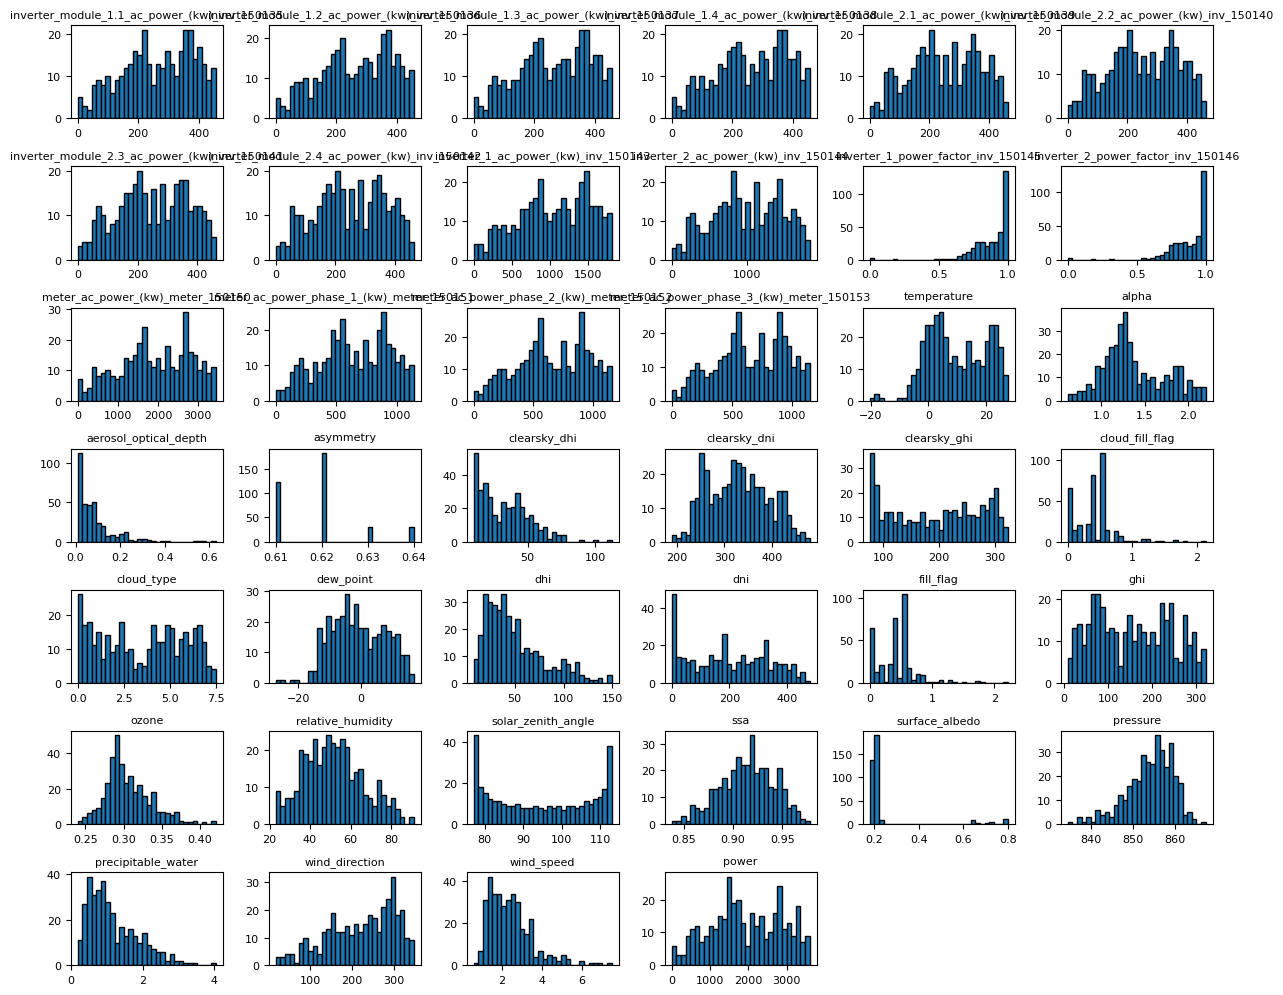

In [42]:
# dropping columns and making histograms
df_daily.drop(columns=["date"], inplace = True)
df_daily.drop(columns=["year"], inplace = True)
df_daily.drop(columns=["month"], inplace = True)
df_daily.drop(columns=["day"], inplace = True)
df_daily.drop(columns=["hour"], inplace = True)
df_daily.drop(columns=["minute"], inplace = True)
df_daily.hist(bins=30, figsize=(12, 10), edgecolor='black', grid = False)
plt.tight_layout()
plt.show()

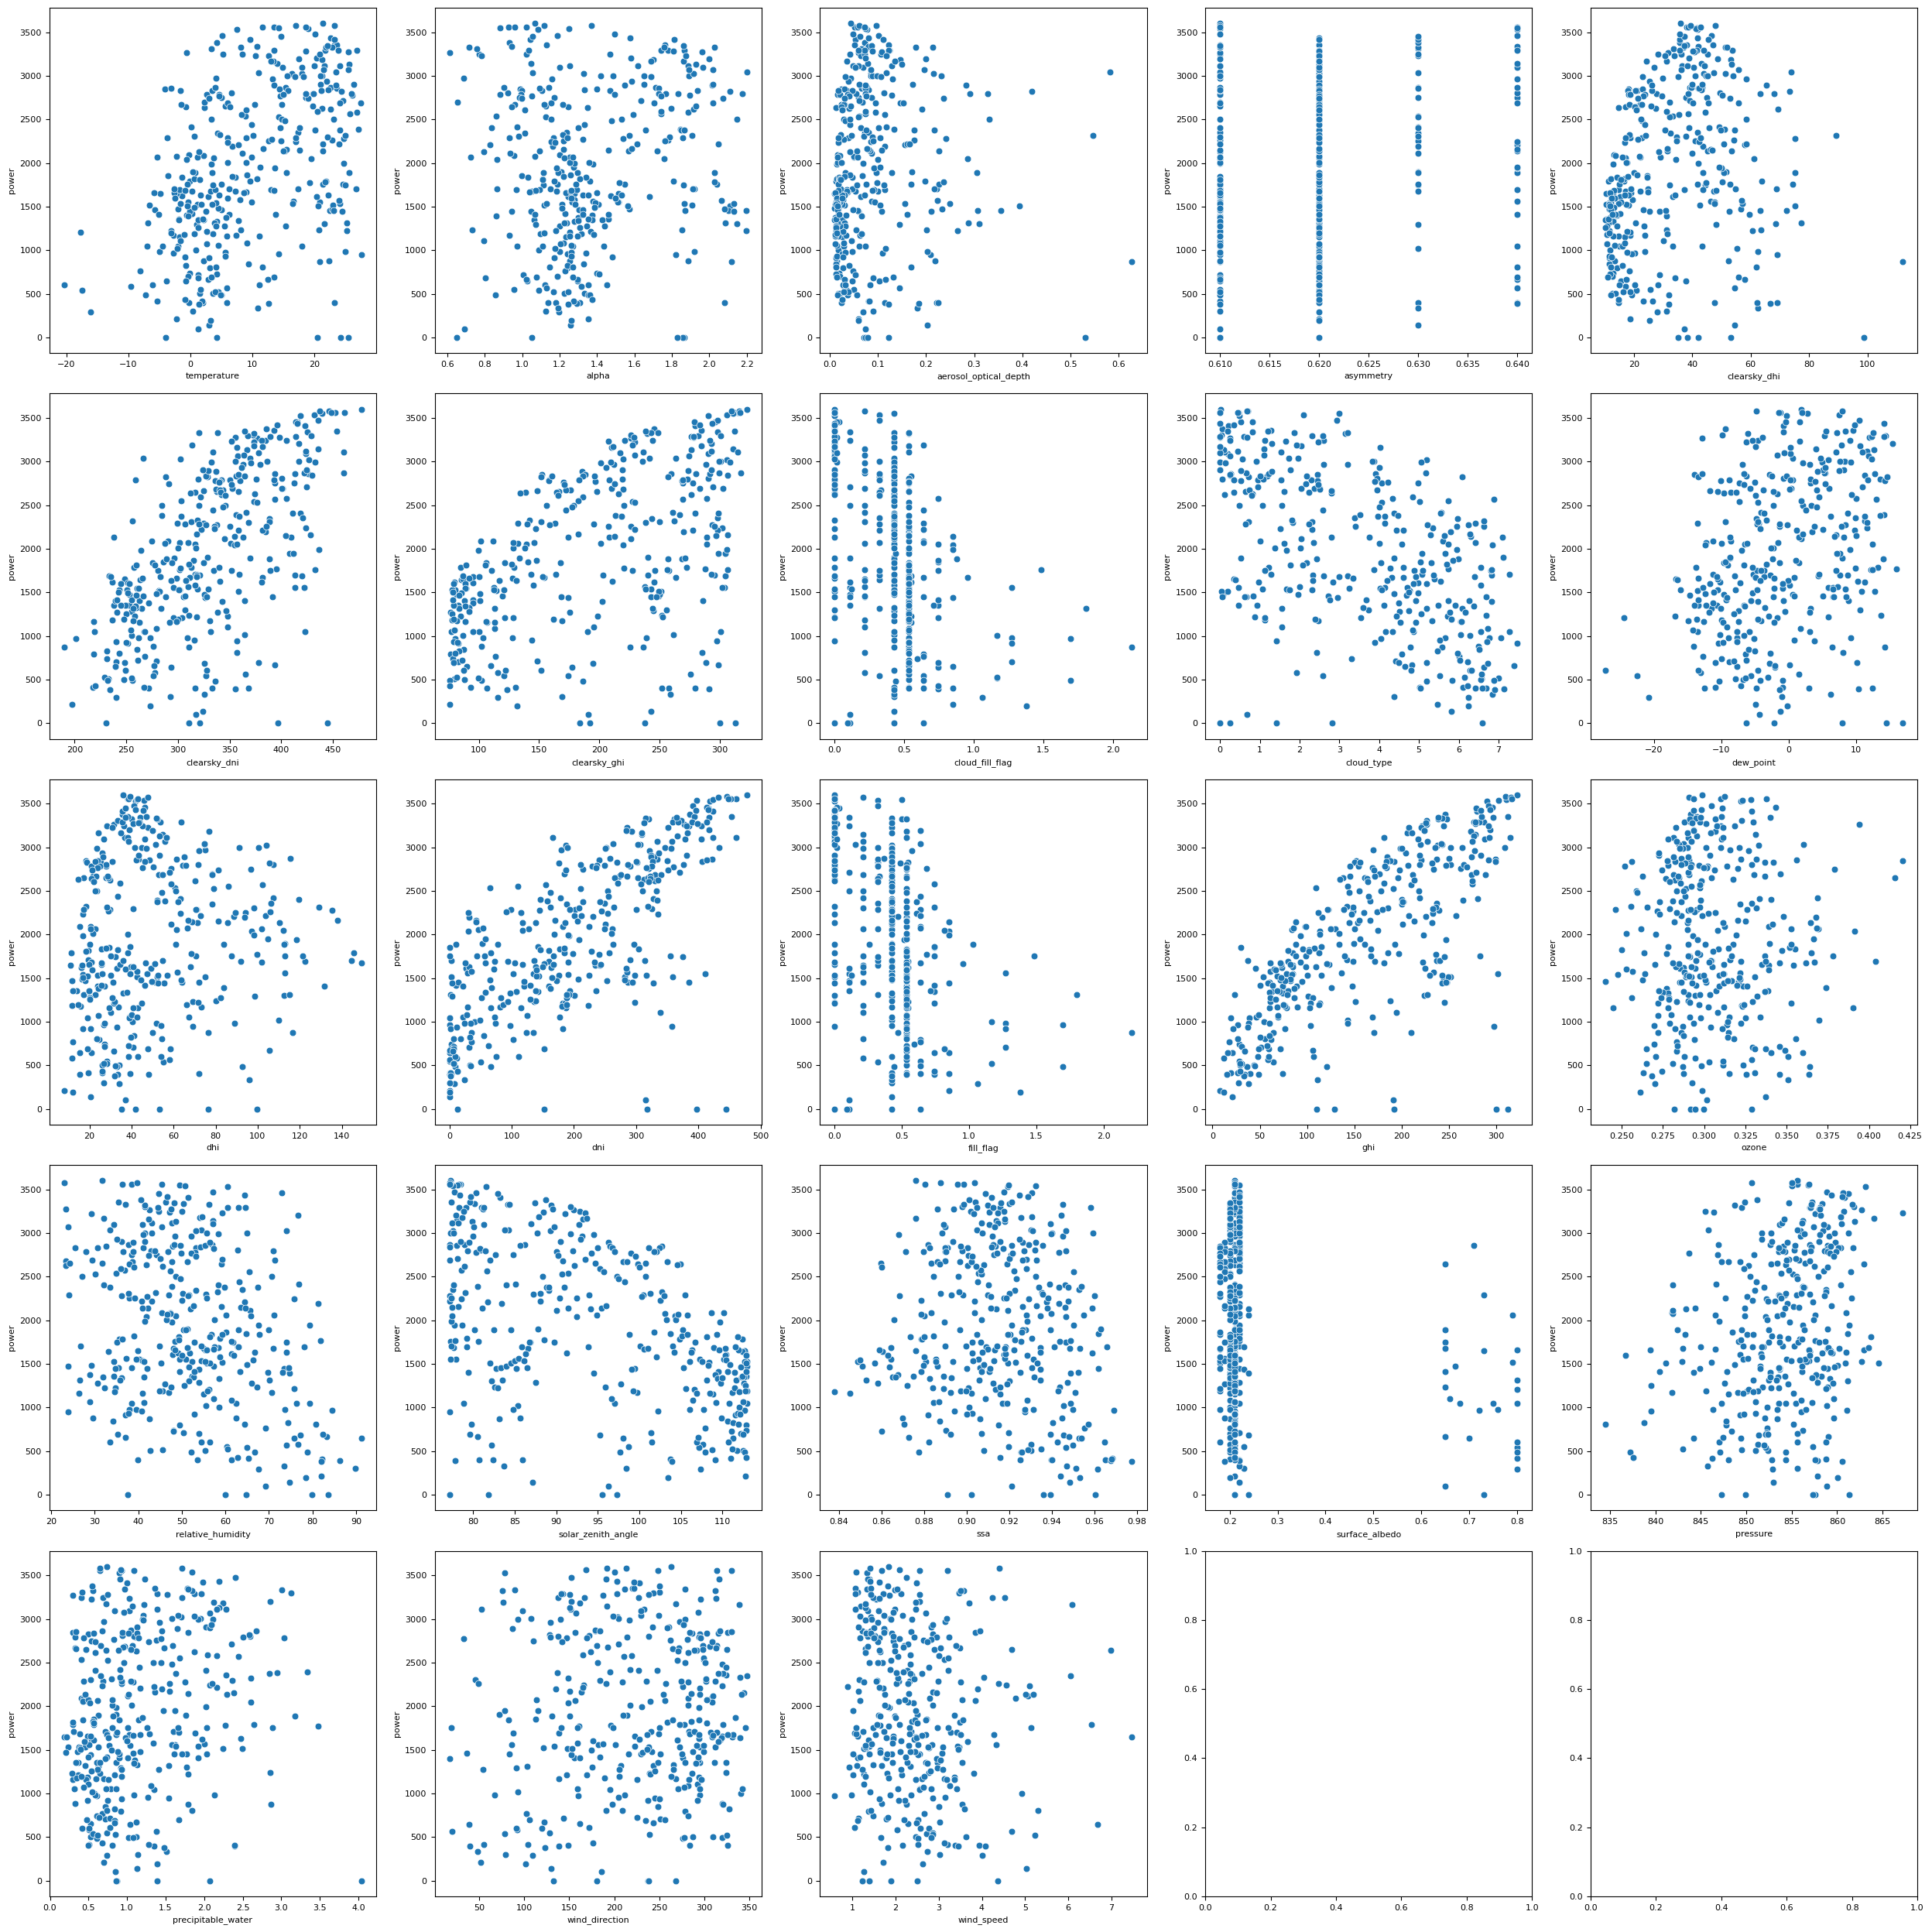

In [43]:
# 2021
target = df_daily.columns[39] # power
features = df_daily.columns[16:39] # all weather features

# looking for correlations
n_features = len(features)
n_cols = 5
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.scatterplot(x=df_daily[feature], y=df_daily[target], ax=axes[i], edgecolor='w', s=40)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)
plt.tight_layout()
plt.show()

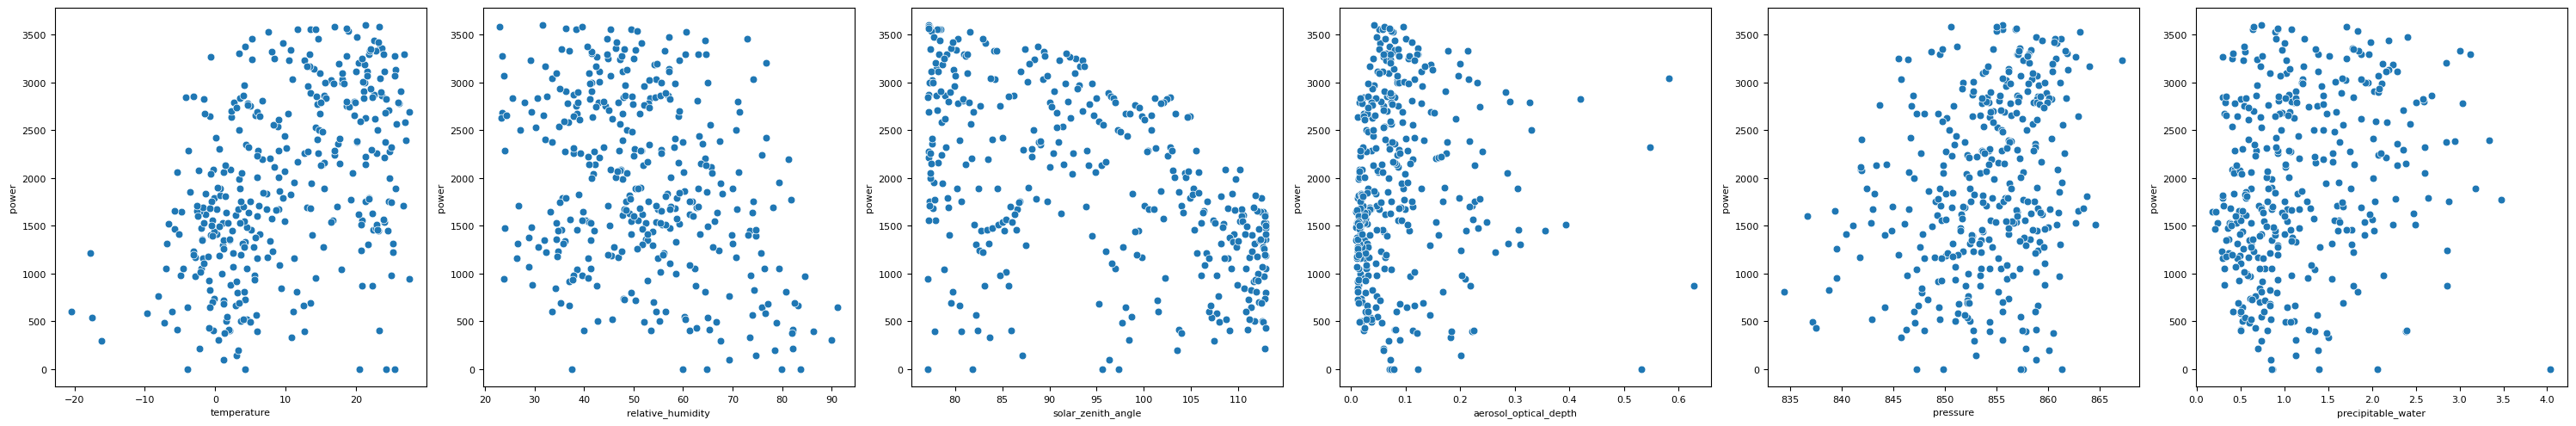

In [44]:
# selecting features based on the correlations
features_0 = ["temperature", "relative_humidity", "solar_zenith_angle", "aerosol_optical_depth", "pressure", "precipitable_water"]
#features_0 = ["temperature", "relative_humidity", "solar_zenith_angle"]
features = features_0

n_features = len(features)
n_cols = len(features)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols,5))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.scatterplot(x=df_daily[feature], y=df_daily[target], ax=axes[i], edgecolor='w', s=40)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)
plt.tight_layout()
plt.show()

In [45]:
df_model = df_daily[[target] + features] # new df
df_model

,power,temperature,relative_humidity,solar_zenith_angle,aerosol_optical_depth,pressure,precipitable_water
0,1050.257576,-2.022727,76.405606,112.928333,0.028000,855.424242,0.783333
1,1473.575758,-1.998485,57.345606,112.931364,0.016636,851.545455,0.356061
2,1186.439394,0.604545,45.500455,112.928636,0.016697,850.075758,0.490909
3,1528.045455,1.086364,52.364394,112.917879,0.011152,856.409091,0.380303
4,795.696970,3.169697,49.551970,112.901970,0.026667,847.803030,0.918182
...,...,...,...,...,...,...,...
360,1193.772727,-3.087879,44.878485,112.805455,0.014030,845.560606,0.404545
361,1597.030303,-2.477273,49.994848,112.842576,0.025636,836.712121,0.443939
362,1413.378788,-5.190909,52.826970,112.871818,0.019606,840.484848,0.493939
363,1505.636364,-0.493939,45.207727,112.897424,0.015788,841.136364,0.400000


In [46]:
# target and features
target = df_model.columns[0] # first column is the target
features = df_model.columns[1:] # the rest are the features

In [47]:
# test set

# 2022
df_power_test = pd.read_csv('9068_ac_power_data.csv') # power data
df_weather_test = pd.read_csv('018febd4ff11ab9992898c87a3a8b784/1000190_40.38_-104.55_2022.csv',skiprows=2) # weather data

df_weather_test.columns = [t.partition('(')[0].strip().lower().replace(' ', '_') for t in df_weather_test.columns] # cleaning up
df_power_test = df_power_test.iloc[1:] # remove header
df_weather_test = df_weather_test.iloc[1:]  # remove header

df_power_test["measured_on"] = pd.to_datetime(df_power_test["measured_on"]) # convert to datetime
df_power_test = df_power_test[df_power_test["measured_on"].dt.minute % 10 == 0] # dt = 10 min
#df_power_test = df_power_test[df_power_test["measured_on"].dt.month.isin([7, 8, 9, 10])] # months 7, 8, 9, 10
df_power_test = df_power_test[df_power_test["measured_on"].dt.year == 2022] # year = 2022
df_power_test=df_power_test[df_power_test["measured_on"].dt.hour.between(7,17)] # consider data between 7am and 5pm
df_power_test_daily=(df_power_test.assign(date=df_power_test["measured_on"].dt.date).groupby("date").mean(numeric_only=True).reset_index()) # take average for each day

df_weather_test["datetime"] = pd.to_datetime(df_weather_test[["year", "month", "day", "hour", "minute"]])
df_weather_test = df_weather_test[df_weather_test["datetime"].dt.minute % 10 == 0] # dt = 10 min
#df_weather_test = df_weather_test[df_weather_test["datetime"].dt.month.isin([7, 8, 9, 10])] # months 7, 8, 9, 10
df_weather_test = df_weather_test[df_weather_test["datetime"].dt.year == 2022] # year = 2022
df_weather_test=df_weather_test[df_weather_test["datetime"].dt.hour.between(7,17)] # consider data between 7am and 5pm
df_weather_test_daily=(df_weather_test.assign(date = df_weather_test["datetime"].dt.date).groupby("date").mean(numeric_only=True).reset_index()) # take average for each day

df_test_daily = pd.merge(df_power_test_daily, df_weather_test_daily, on="date", how="inner") # merging data

df_test_daily["power"] = df_test_daily[["inverter_1_ac_power_(kw)_inv_150143","inverter_2_ac_power_(kw)_inv_150144"]].sum(axis=1) # defining power column

df_test_daily.drop(columns=["date"], inplace = True)
df_test_daily.drop(columns=["year"], inplace = True)
df_test_daily.drop(columns=["month"], inplace = True)
df_test_daily.drop(columns=["day"], inplace = True)
df_test_daily.drop(columns=["hour"], inplace = True)
df_test_daily.drop(columns=["minute"], inplace = True)

target = df_test_daily.columns[39]
features = features_0

df_test_model = df_test_daily[[target] + features]

df_test_model


,power,temperature,relative_humidity,solar_zenith_angle,aerosol_optical_depth,pressure,precipitable_water
0,39.272727,-11.287879,65.233485,112.922879,0.071182,846.363636,0.462121
1,210.439394,-7.327273,46.546212,112.929394,0.010000,854.606061,0.409091
2,410.287879,-2.360606,60.892424,112.928788,0.010576,855.166667,0.400000
3,1017.484848,0.946970,48.683030,112.920606,0.011545,845.924242,0.395455
4,385.318182,-3.778788,66.863030,112.905606,0.017758,848.818182,0.672727
...,...,...,...,...,...,...,...
360,832.318182,3.578788,68.544545,112.798788,0.010000,848.045455,0.722727
361,438.000000,4.775758,65.158030,112.836515,0.026818,837.287879,1.246970
362,1031.424242,-0.774242,58.570909,112.867273,0.020818,844.545455,0.539394
363,1202.090909,-2.584848,46.639545,112.891515,0.014636,849.136364,0.434848


In [48]:
df_train=df_model # 2021
df_test=df_test_model # 2022

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import scipy.sparse
from pygam import LinearGAM, s
from functools import reduce

def to_array(self):
    return self.toarray()

scipy.sparse.spmatrix.A = property(to_array)

def build_gam(X, lam=100):
    terms = reduce(lambda a, b: a + b, [s(i) for i in range(X.shape[1])])
    return LinearGAM(terms, lam=lam)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = np.full((5, 2), np.nan)

X = df_train[features]
y = df_train[target]

for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    linear_pred = linear.predict(X_val)
    linear_rmse = root_mean_squared_error(y_val, linear_pred)
    rmse_scores[i,0] = linear_rmse

    gam = build_gam(X_train)
    gam.fit(X_train, y_train)
    gam_pred = gam.predict(X_val)
    gam_rmse = root_mean_squared_error(y_val, gam_pred)
    rmse_scores[i,1] = gam_rmse

print(f'RMSEs on each fold: \n {np.round(rmse_scores,2)}')
print(f'Mean RMSE: {np.round(np.mean(rmse_scores, axis = 0),2)}')
print(f'Standard deviation: {np.round(np.std(rmse_scores, axis = 0),2)}')

RMSEs on each fold: 
 [[746.65 723.04]
 [704.71 708.76]
 [658.56 624.43]
 [738.17 662.83]
 [684.46 574.23]]
Mean RMSE: [706.51 658.66]
Standard deviation: [32.87 54.72]


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

linear = LinearRegression().fit(X_train, y_train)
gam = build_gam(X_train).fit(X_train, y_train)

y_pred_lr = linear.predict(X_test)
y_pred_gam = gam.predict(X_test)

def print_metrics(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print(f"  R2   : {r2_score(y_true, y_pred):.3f}")
    print(f"  MAE  : {mean_absolute_error(y_true, y_pred):.3f}")
    print(f"  RMSE : {root_mean_squared_error(y_true, y_pred):.3f}")

print_metrics("Linear Regression", y_test, y_pred_lr)
print_metrics("GAM", y_test, y_pred_gam)


Linear Regression Performance:
  R2   : 0.576
  MAE  : 478.196
  RMSE : 604.506

GAM Performance:
  R2   : 0.554
  MAE  : 482.132
  RMSE : 620.081


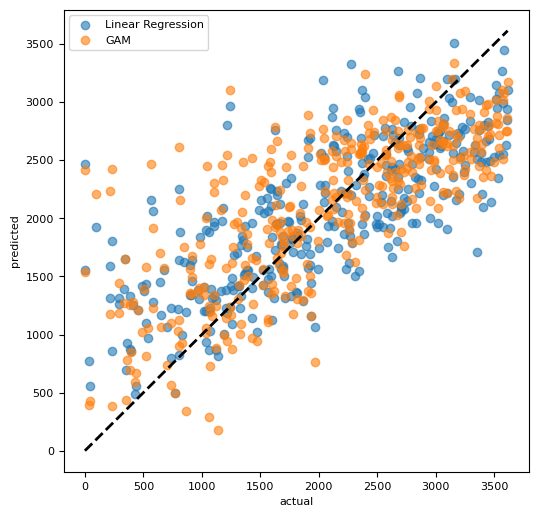

In [51]:
# predictions vs actuals

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label="Linear Regression")
plt.scatter(y_test, y_pred_gam, alpha=0.6, label="GAM")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("actual")
plt.ylabel("predicted")
plt.legend()
plt.show()


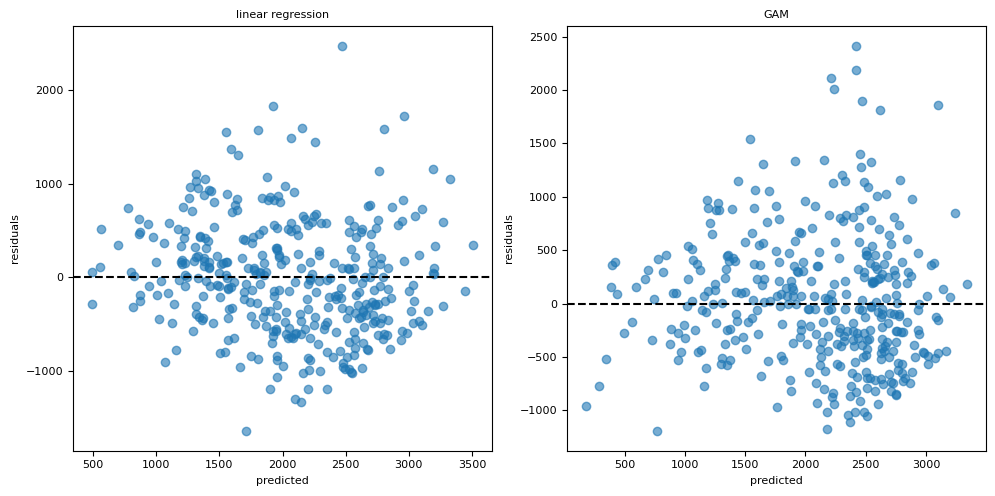

In [52]:
# residuals

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_pred_lr, y_pred_lr - y_test, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.title("linear regression")
plt.xlabel("predicted")
plt.ylabel("residuals")

plt.subplot(1,2,2)
plt.scatter(y_pred_gam, y_pred_gam - y_test, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.title("GAM")
plt.xlabel("predicted")
plt.ylabel("residuals")

plt.tight_layout()
plt.show()


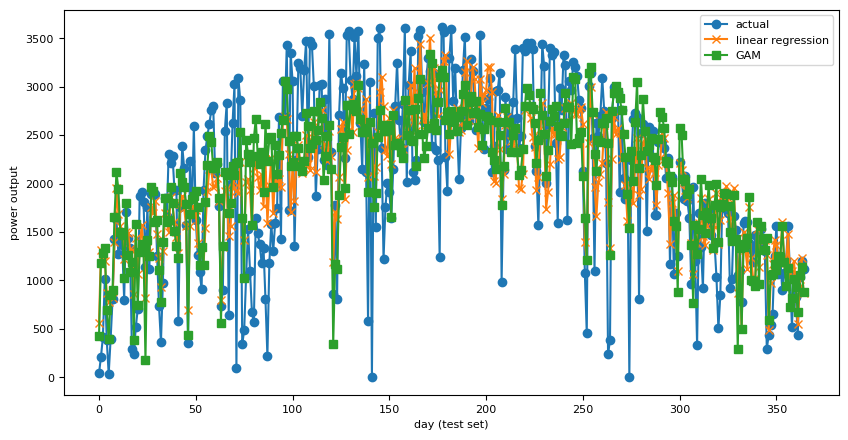

In [53]:
# time series comparison

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="actual", marker='o')
plt.plot(y_pred_lr, label="linear regression", marker='x')
plt.plot(y_pred_gam, label="GAM", marker='s')
plt.legend()
plt.xlabel("day (test set)")
plt.ylabel("power output")
plt.show()

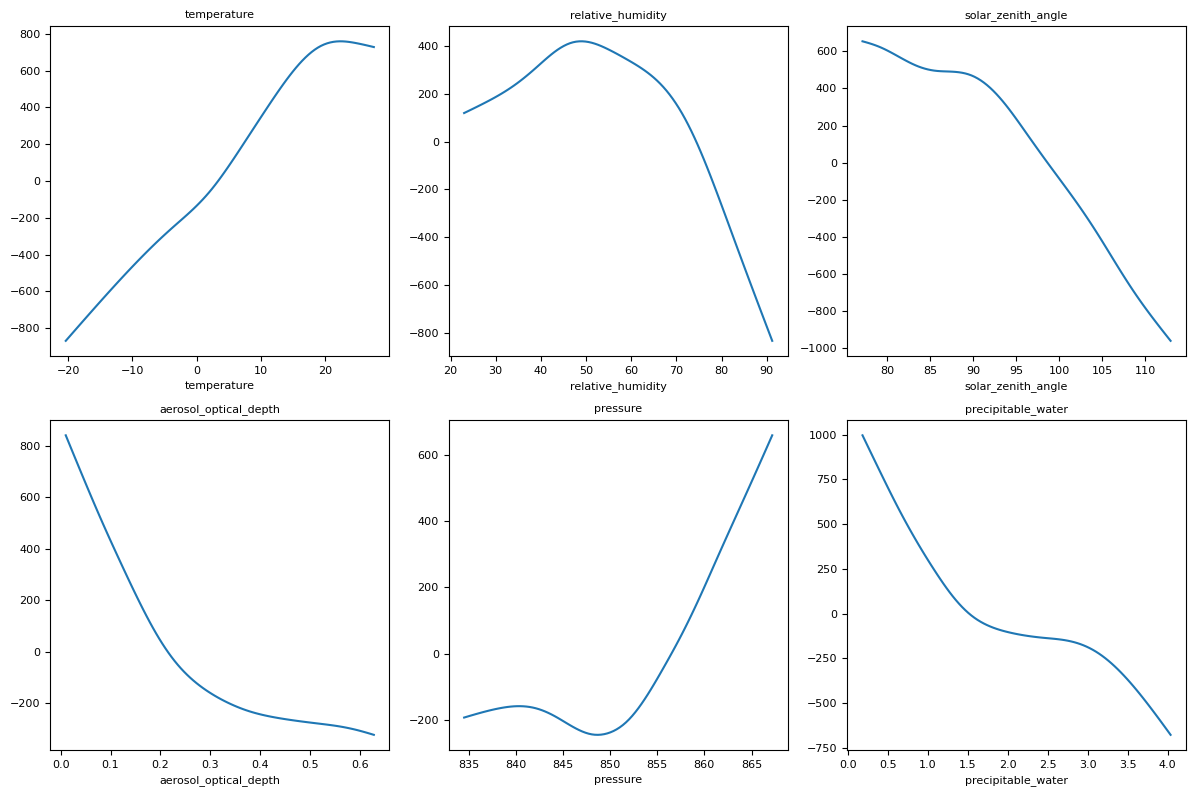

In [54]:
#gam.summary()  # text summary with statistics for each smooth term

plt.figure(figsize=(12,8))
for i, feature in enumerate(features):
    plt.subplot(2, int(np.ceil(len(features)/2)), i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(feature)
    plt.xlabel(feature)
plt.tight_layout()
plt.show()


In [55]:
# comparing models

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def build_gam(X, lam=100):
    terms = reduce(lambda a, b: a + b, [s(i) for i in range(X.shape[1])])
    return LinearGAM(terms, lam=lam)

X = df_train[features]
y = df_train[target]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = np.full((5, 5), np.nan)
model_names = ["Linear", "GAM", "RandomForest", "GradBoost", "XGBoost"]

for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Linear
    linear = LinearRegression().fit(X_train, y_train)
    y_pred = linear.predict(X_val)
    rmse_scores[i, 0] = root_mean_squared_error(y_val, y_pred)

    # GAM
    gam = build_gam(X_train).fit(X_train, y_train)
    y_pred = gam.predict(X_val)
    rmse_scores[i, 1] = root_mean_squared_error(y_val, y_pred)

    # RandomForest
    rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_scores[i, 2] = root_mean_squared_error(y_val, y_pred)

    # GradBoost
    gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42).fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    rmse_scores[i, 3] = root_mean_squared_error(y_val, y_pred)

    # XGBoost
    xgb = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        n_jobs=-1, verbosity=0
    ).fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    rmse_scores[i, 4] = root_mean_squared_error(y_val, y_pred)

mean_rmse = np.mean(rmse_scores, axis=0)
std_rmse  = np.std(rmse_scores, axis=0)

print("RMSEs on each fold:\n", np.round(rmse_scores, 2))
print("\nMean RMSE:", dict(zip(model_names, np.round(mean_rmse, 2))))
print("Std RMSE :", dict(zip(model_names, np.round(std_rmse, 2))))


RMSEs on each fold:
 [[746.65 723.04 594.13 594.9  600.5 ]
 [704.71 708.76 699.91 728.21 746.37]
 [658.56 624.43 604.3  672.52 655.01]
 [738.17 662.83 669.52 658.52 647.66]
 [684.46 574.23 528.74 576.18 538.03]]

Mean RMSE: {'Linear': np.float64(706.51), 'GAM': np.float64(658.66), 'RandomForest': np.float64(619.32), 'GradBoost': np.float64(646.07), 'XGBoost': np.float64(637.51)}
Std RMSE : {'Linear': np.float64(32.87), 'GAM': np.float64(54.72), 'RandomForest': np.float64(60.13), 'GradBoost': np.float64(54.96), 'XGBoost': np.float64(68.59)}


Best model from cross-validation: RandomForest
Mean CV RMSE: 619.321

Final Evaluation on Test Set:
MAE  = 495.227
RMSE = 657.126
R2   = 0.499


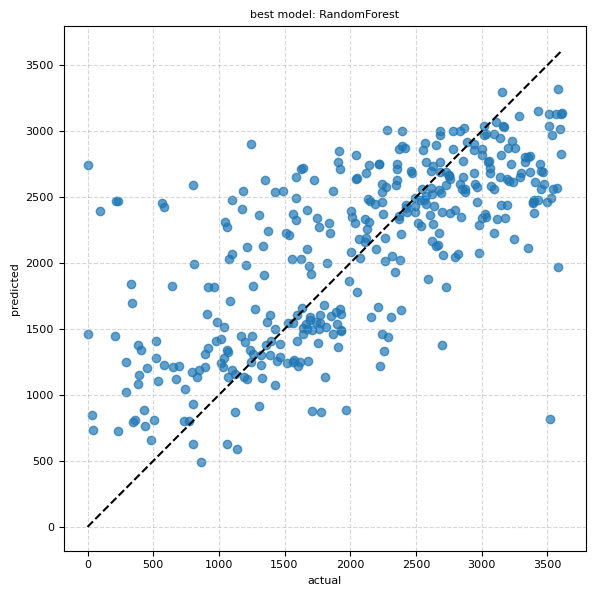

In [56]:
# best model from cross-validation
mean_rmse = np.mean(rmse_scores, axis=0)
best_model_idx = np.argmin(mean_rmse)
best_model_name = model_names[best_model_idx]

print(f"Best model from cross-validation: {best_model_name}")
print(f"Mean CV RMSE: {mean_rmse[best_model_idx]:.3f}")

# retrain best model on all training data
if best_model_name == "Linear":
    final_model = LinearRegression()
elif best_model_name == "GAM":
    final_model = build_gam(df_train[features])
elif best_model_name == "RandomForest":
    final_model = RandomForestRegressor(random_state=42)
elif best_model_name == "XGBoost":
    final_model = XGBRegressor(objective="reg:squarederror", random_state=42)
elif best_model_name == "GradBoost":
    final_model = GradientBoostingRegressor(random_state=42)
else:
    raise ValueError("Unexpected model name")

final_model.fit(df_train[features], df_train[target])

# evaluate on test set
y_pred = final_model.predict(df_test[features])
y_true = df_test[target]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\nFinal Evaluation on Test Set:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R2   = {r2:.3f}")

# predicted vs actuals
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title(f"best model: {best_model_name}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


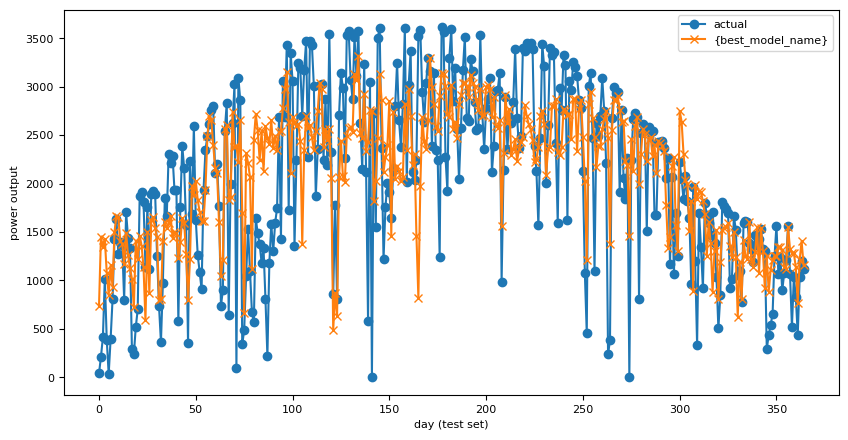

In [57]:
# time series comparison

plt.figure(figsize=(10,5))
plt.plot(y_true, label="actual", marker='o')
plt.plot(y_pred, label=f"{best_model_name}", marker='x')
plt.legend()
plt.xlabel("day (test set)")
plt.ylabel("power output")
plt.show()
